In [ ]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import zipfile
import cv2
import numpy as np
from collections import Counter
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import time
from sklearn.metrics import precision_recall_fscore_support
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def worker_init_fn(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

zip_path = "cnn_dataset.zip"
extract_folder = "cnn_dataset"
os.makedirs(extract_folder, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)
### ADD YOUR CODE HERE ###
data_path = "cnn_dataset"
class_names = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]


class_counts = {}
image_shapes = []

for class_name in class_names:
    class_path = os.path.join(data_path, class_name)
    images = [img for img in os.listdir(class_path) if img.endswith(('jpg', 'jpeg', 'png'))]
    class_counts[class_name] = len(images)

    for img_name in images[:10]:
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            image_shapes.append(img.shape)

total_images = sum(class_counts.values())

class_distribution = {cls: round((count / total_images) * 100, 2) for cls, count in class_counts.items()}


image_shapes = np.array(image_shapes)
avg_height = int(np.mean(image_shapes[:, 0])) if len(image_shapes) > 0 else 0
avg_width = int(np.mean(image_shapes[:, 1])) if len(image_shapes) > 0 else 0

print("Dataset Statistics")
print(f"Total Images: {total_images}")
print("Class-wise Distribution:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} images ({class_distribution[cls]}%)")
print(f"Average Image Size: {avg_height}x{avg_width} pixels")


transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_val = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


### ADD YOUR CODE HERE ###
output_path = "split"

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

os.makedirs(output_path, exist_ok=True)

for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(output_path, split), exist_ok=True)


for class_name in class_names:
    class_path = os.path.join(data_path, class_name)

    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(output_path, split, class_name), exist_ok=True)

    images = [img for img in os.listdir(class_path) if img.endswith(("jpg", "jpeg", "png"))]
    random.shuffle(images)

    train_files, test_val_files = train_test_split(images, test_size=(val_ratio + test_ratio), random_state=SEED
)
    val_files, test_files = train_test_split(test_val_files, test_size=test_ratio / (test_ratio + val_ratio), random_state=SEED
)

    for file_name in train_files:
        shutil.copy(os.path.join(class_path, file_name), os.path.join(output_path, "train", class_name, file_name))
    for file_name in val_files:
        shutil.copy(os.path.join(class_path, file_name), os.path.join(output_path, "val", class_name, file_name))
    for file_name in test_files:
        shutil.copy(os.path.join(class_path, file_name), os.path.join(output_path, "test", class_name, file_name))

train_dir = "split/train/"
val_dir = "split/val/"
test_dir = "split/test/"

transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_val = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = ImageFolder(root=train_dir, transform=transform_train)
val_dataset = ImageFolder(root=val_dir, transform=transform_val)


transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_dataset = ImageFolder(root=test_dir, transform=transform)

print("Dataset successfully split into train, val, and test sets!")


Dataset Statistics
Total Images: 30000
Class-wise Distribution:
vehicles: 10000 images (33.33%)
food: 10000 images (33.33%)
dogs: 10000 images (33.33%)
Average Image Size: 64x64 pixels
Dataset successfully split into train, val, and test sets!


Training and evaluation fucntion

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


def train_model(model, optimizer, scheduler, criterion, train_dataset, val_dataset, batch_size, epochs, device):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [],
               'train_precision': [], 'val_precision': [], 'train_recall': [], 'val_recall': [],
               'train_f1': [], 'val_f1': []}

    model.to(device)

    for epoch in range(epochs):
        start_time = time.time()

        model.train()
        train_losses, y_true_train, y_pred_train = [], [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            _, preds = torch.max(outputs, 1)
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())

        if scheduler:
            scheduler.step()

        train_loss = sum(train_losses) / len(train_losses)
        train_acc = accuracy_score(y_true_train, y_pred_train) * 100
        train_precision = precision_score(y_true_train, y_pred_train, average='weighted', zero_division=0)
        train_recall = recall_score(y_true_train, y_pred_train, average='weighted', zero_division=0)
        train_f1 = f1_score(y_true_train, y_pred_train, average='weighted', zero_division=0)

        val_metrics = evaluate_model(model, criterion, val_loader, device)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_metrics['loss'])
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_metrics['accuracy'])
        history['train_precision'].append(train_precision)
        history['val_precision'].append(val_metrics['precision'])
        history['train_recall'].append(train_recall)
        history['val_recall'].append(val_metrics['recall'])
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_metrics['f1'])

        end_time = time.time()

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Time: {end_time - start_time:.2f}s")
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_metrics['loss']:.4f}")
        print(f"Train Acc: {train_acc:.2f}%, Val Acc: {val_metrics['accuracy']:.2f}%")
        print(f"Train Precision: {train_precision:.4f}, Val Precision: {val_metrics['precision']:.4f}")
        print(f"Train Recall: {train_recall:.4f}, Val Recall: {val_metrics['recall']:.4f}")
        print(f"Train F1: {train_f1:.4f}, Val F1: {val_metrics['f1']:.4f}")
        print('-' * 40)

    return model, history


def evaluate_model(model, criterion, data_loader, device):
    model.eval()
    losses, y_true, y_pred = [], [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    metrics = {
        'loss': sum(losses) / len(losses),
        'accuracy': accuracy_score(y_true, y_pred) * 100,
        'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1': f1_score(y_true, y_pred, average='weighted', zero_division=0)
    }

    return metrics


VGG Model

In [ ]:
class VGG_C(nn.Module):
    def __init__(self, num_classes=3, input_size=64):
        super(VGG_C, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        with torch.no_grad():
            sample_input = torch.randn(1, 3, input_size, input_size)
            sample_output = self.layers(sample_input)
            flattened_size = sample_output.view(1, -1).shape[1]

        self.final_layer = nn.Sequential(
            nn.Linear(flattened_size, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x, dropout_layer=None):
        x = self.layers(x)
        x = torch.flatten(x, start_dim=1)
        if dropout_layer:
            x = dropout_layer(x)
        x = self.final_layer(x)
        return x

    def initialize_weights_kaiming(self):
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

    def initialize_weights_xavier(self):
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)


ResNet Model

In [ ]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_downsample=False, use_batchnorm=True):
        super(ResidualBlock, self).__init__()

        self.use_batchnorm = use_batchnorm

        self.main_path = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels) if self.use_batchnorm else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels) if self.use_batchnorm else nn.Identity(),
        )

        self.shortcut = (
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels) if self.use_batchnorm else nn.Identity(),
            )
            if use_downsample or in_channels != out_channels
            else nn.Identity()
        )

        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.main_path(x)
        out += identity
        return self.activation(out)

class ResNet18(nn.Module):
    def __init__(self, num_classes=3, use_batchnorm=True):
        super(ResNet18, self).__init__()
        self.use_batchnorm = use_batchnorm

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64) if self.use_batchnorm else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        self.layer1 = self._make_layer(64, 64, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, num_blocks=2, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride, use_downsample=True, use_batchnorm=self.use_batchnorm))

        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, use_batchnorm=self.use_batchnorm))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)



In [ ]:

model = VGG_C(num_classes=3, input_size=64)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = None
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size=32
epochs=5
trained_model, history = train_model(model, optimizer, scheduler, criterion, train_dataset, val_dataset, batch_size, epochs, device)


Epoch 1/5
Time: 99.42s
Train Loss: 0.6318, Val Loss: 0.5526
Train Acc: 75.82%, Val Acc: 79.09%
Train Precision: 0.7584, Val Precision: 0.8036
Train Recall: 0.7582, Val Recall: 0.7909
Train F1: 0.7581, Val F1: 0.7872
----------------------------------------
Epoch 2/5
Time: 99.28s
Train Loss: 0.4924, Val Loss: 0.3873
Train Acc: 81.21%, Val Acc: 86.36%
Train Precision: 0.8120, Val Precision: 0.8642
Train Recall: 0.8121, Val Recall: 0.8636
Train F1: 0.8120, Val F1: 0.8624
----------------------------------------
Epoch 3/5
Time: 99.31s
Train Loss: 0.4580, Val Loss: 0.4793
Train Acc: 82.56%, Val Acc: 83.31%
Train Precision: 0.8255, Val Precision: 0.8388
Train Recall: 0.8256, Val Recall: 0.8331
Train F1: 0.8255, Val F1: 0.8339
----------------------------------------
Epoch 4/5
Time: 99.00s
Train Loss: 0.4086, Val Loss: 2.7992
Train Acc: 85.29%, Val Acc: 65.07%
Train Precision: 0.8530, Val Precision: 0.6591
Train Recall: 0.8529, Val Recall: 0.6507
Train F1: 0.8529, Val F1: 0.6461
-------------

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_metrics = evaluate_model(model, criterion, test_loader, device)
print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")


Test Accuracy: 88.3778


In [ ]:
model2 = ResNet18(num_classes=3, use_batchnorm=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
scheduler = None
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size=32
epochs=5
trained_model2, history2 = train_model(model2, optimizer, scheduler, criterion, train_dataset, val_dataset, batch_size, epochs, device)


Epoch 1/5
Time: 53.03s
Train Loss: 0.5019, Val Loss: 0.5008
Train Acc: 80.34%, Val Acc: 81.71%
Train Precision: 0.8042, Val Precision: 0.8276
Train Recall: 0.8034, Val Recall: 0.8171
Train F1: 0.8036, Val F1: 0.8187
----------------------------------------
Epoch 2/5
Time: 53.21s
Train Loss: 0.3791, Val Loss: 0.3376
Train Acc: 85.22%, Val Acc: 87.38%
Train Precision: 0.8525, Val Precision: 0.8757
Train Recall: 0.8522, Val Recall: 0.8738
Train F1: 0.8523, Val F1: 0.8728
----------------------------------------
Epoch 3/5
Time: 52.70s
Train Loss: 0.3271, Val Loss: 0.3067
Train Acc: 87.32%, Val Acc: 88.64%
Train Precision: 0.8733, Val Precision: 0.8893
Train Recall: 0.8732, Val Recall: 0.8864
Train F1: 0.8732, Val F1: 0.8872
----------------------------------------
Epoch 4/5
Time: 52.87s
Train Loss: 0.3001, Val Loss: 0.2580
Train Acc: 88.68%, Val Acc: 90.62%
Train Precision: 0.8870, Val Precision: 0.9073
Train Recall: 0.8868, Val Recall: 0.9062
Train F1: 0.8868, Val F1: 0.9063
-------------

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_metrics = evaluate_model(model2, criterion, test_loader, device)
print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")


Test Accuracy: 82.0222


# ResNeXt [7 points]
Based on your ResNet implementation in Part I, extend it to ResNeXT. It is expected that your accuracy is higher than ResNet. Compare the results with your VGG and ResNet implementation.

## Step 1: Implement the ResNeXT architecture
Pay close attention to the grouped convolutions and cardinality parameter. Using inbuild ResNeXt model won’t be considered for evaluation.

In [ ]:
class ResNeXtBlock(nn.Module):
    expansion = 2

    def __init__(self, in_channels, out_channels, stride, cardinality, bottleneck_width):
        super(ResNeXtBlock, self).__init__()

        D = cardinality * bottleneck_width

        self.conv1 = nn.Conv2d(in_channels, D, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(D)
        self.conv2 = nn.Conv2d(D, D, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
        self.bn2 = nn.BatchNorm2d(D)
        self.conv3 = nn.Conv2d(D, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        out += identity
        return self.relu(out)


class CustomResNeXt(nn.Module):
    def __init__(self, num_classes=3, cardinality=32, bottleneck_width=4):
        super(CustomResNeXt, self).__init__()

        self.cardinality = cardinality
        self.bottleneck_width = bottleneck_width

        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.layer1 = self._make_layer(64, 128, stride=1)
        self.layer2 = self._make_layer(128, 256, stride=2)
        self.layer3 = self._make_layer(256, 512, stride=2)
        self.layer4 = self._make_layer(512, 1024, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, num_classes)

    def _make_layer(self, in_channels, out_channels, stride):
        layers = [ResNeXtBlock(in_channels, out_channels, stride, self.cardinality, self.bottleneck_width)]
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


## Step 2: Train and evaluate your ResNeXt model
Train and evaluate your ResNeXt model on the same dataset used in Part I.

In [ ]:
### ADD YOUR CODE HERE ###
model3 = CustomResNeXt(num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.0001)
scheduler = None
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size=32
epochs=5
trained_model3, history3 = train_model(model3, optimizer, scheduler, criterion, train_dataset, val_dataset, batch_size, epochs, device)


Epoch 1/5
Time: 52.33s
Train Loss: 0.5789, Val Loss: 0.4015
Train Acc: 75.81%, Val Acc: 84.38%
Train Precision: 0.7581, Val Precision: 0.8439
Train Recall: 0.7581, Val Recall: 0.8438
Train F1: 0.7580, Val F1: 0.8437
----------------------------------------
Epoch 2/5
Time: 52.44s
Train Loss: 0.4208, Val Loss: 0.3429
Train Acc: 83.52%, Val Acc: 87.11%
Train Precision: 0.8355, Val Precision: 0.8733
Train Recall: 0.8352, Val Recall: 0.8711
Train F1: 0.8352, Val F1: 0.8707
----------------------------------------
Epoch 3/5
Time: 51.75s
Train Loss: 0.3735, Val Loss: 0.3140
Train Acc: 85.35%, Val Acc: 87.98%
Train Precision: 0.8537, Val Precision: 0.8797
Train Recall: 0.8535, Val Recall: 0.8798
Train F1: 0.8535, Val F1: 0.8795
----------------------------------------
Epoch 4/5
Time: 52.05s
Train Loss: 0.3493, Val Loss: 0.3033
Train Acc: 86.53%, Val Acc: 88.51%
Train Precision: 0.8656, Val Precision: 0.8869
Train Recall: 0.8653, Val Recall: 0.8851
Train F1: 0.8653, Val F1: 0.8850
-------------

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_metrics = evaluate_model(model3, criterion, test_loader, device)
print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")

Test Accuracy: 89.8000


## Step 3: Compare the performance of your ResNeXt model
Compare the performance of your ResNeXt model against your previous ResNet and VGG models. Provide a detailed analysis of the results.

### a. A table summarizing the performance metrics (accuracy, loss, etc.) for all three models.

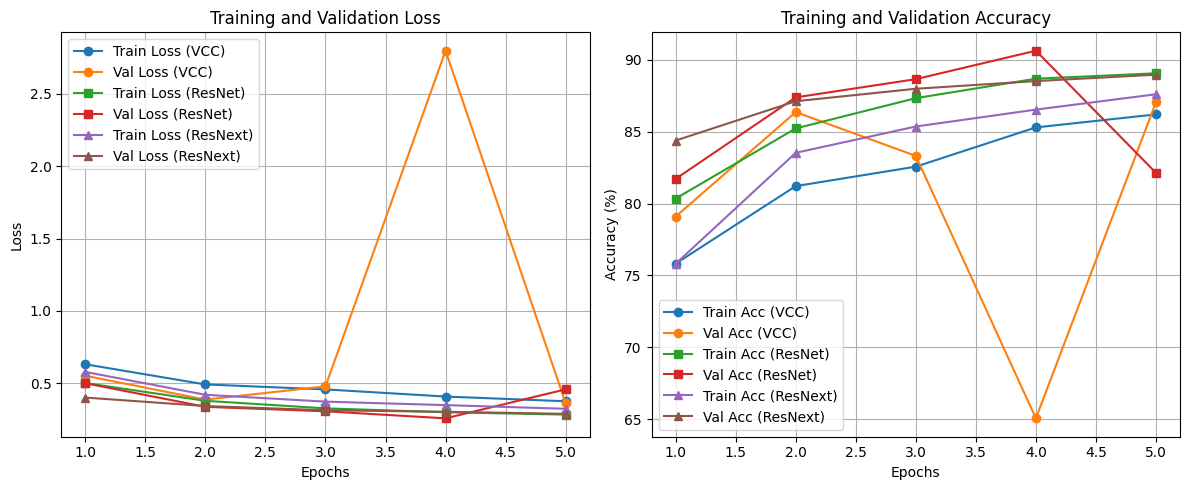

Epoch  Train Loss (M1)  Val Loss (M1)  Train Acc (M1)  Val Acc (M1)  \
0      1         0.631754       0.552558       75.819048     79.088889   
1      2         0.492355       0.387312       81.209524     86.355556   
2      3         0.457965       0.479345       82.561905     83.311111   
3      4         0.408625       2.799198       85.290476     65.066667   
4      5         0.376083       0.362745       86.195238     87.044444   

   Train Loss (M2)  Val Loss (M2)  Train Acc (M2)  Val Acc (M2)  \
0         0.501933       0.500826       80.342857     81.711111   
1         0.379147       0.337614       85.219048     87.377778   
2         0.327084       0.306690       87.323810     88.644444   
3         0.300111       0.257986       88.676190     90.622222   
4         0.283980       0.458363       89.052381     82.133333   

   Train Loss (M3)  Val Loss (M3)  Train Acc (M3)  Val Acc (M3)  
0         0.578888       0.401543       75.809524     84.377778  
1         0.420758       0.342933       83.523810     87.111111  
2         0.373493       0.314045       85.352381     87.977778  
3         0.349343       0.303322       86.528571     88.511111  
4         0.323971       0.288974       87.595238     88.955556

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

epochs = range(1, 6)

# Plotting loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], 'o-', label='Train Loss (VCC)')
plt.plot(epochs, history['val_loss'], 'o-', label='Val Loss (VCC)')
plt.plot(epochs, history2['train_loss'], 's-', label='Train Loss (ResNet)')
plt.plot(epochs, history2['val_loss'], 's-', label='Val Loss (ResNet)')
plt.plot(epochs, history3['train_loss'], '^-', label='Train Loss (ResNext)')
plt.plot(epochs, history3['val_loss'], '^-', label='Val Loss (ResNext)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], 'o-', label='Train Acc (VCC)')
plt.plot(epochs, history['val_acc'], 'o-', label='Val Acc (VCC)')
plt.plot(epochs, history2['train_acc'], 's-', label='Train Acc (ResNet)')
plt.plot(epochs, history2['val_acc'], 's-', label='Val Acc (ResNet)')
plt.plot(epochs, history3['train_acc'], '^-', label='Train Acc (ResNext)')
plt.plot(epochs, history3['val_acc'], '^-', label='Val Acc (ResNext)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Creating dataframes for table display
data = {
    'Epoch': epochs,
    'Train Loss (M1)': history['train_loss'],
    'Val Loss (M1)': history['val_loss'],
    'Train Acc (M1)': history['train_acc'],
    'Val Acc (M1)': history['val_acc'],
    'Train Loss (M2)': history2['train_loss'],
    'Val Loss (M2)': history2['val_loss'],
    'Train Acc (M2)': history2['train_acc'],
    'Val Acc (M2)': history2['val_acc'],
    'Train Loss (M3)': history3['train_loss'],
    'Val Loss (M3)': history3['val_loss'],
    'Train Acc (M3)': history3['train_acc'],
    'Val Acc (M3)': history3['val_acc'],
}

df = pd.DataFrame(data)
df


In [ ]:
torch.save(trained_model3.state_dict(), 'resnext_model.pt')

<span style='color:green'>### YOUR ANSWER ###</span>

### b. Discussion of the observed differences in performance.
Explain why ResNeXt might be outperforming ResNet and VGG. Consider factors like cardinality, grouped convolutions, and the overall architecture.

ResNeXt is an optimised deep learning architerature which built upon ResNet's Resduial learning and introduces cardinality which refers to the number of parallel paths or groups within each block of the network. This cardinality allows the model to extract more diverse features, which helps in improving model generalization and reducing overfitting. ResNeXt uses grouped convolutions to reduce the number of parameters while still maintaining expressiveness, unlike ResNet, which uses standard convolutions in the residual block. Both ResNet and ResNeXt use a 1x1 → 3x3 → 1x1 bottleneck structure, which aids in feature learning and reduces the number of parameters.

<span style='color:green'>### YOUR ANSWER ###</span>


### c. Analysis of any challenges encountered during the implementation or training process.

<span style='color:green'>### YOUR ANSWER ###</span>

### d. Provide detailed analysis of the results.

<span style='color:green'>### YOUR ANSWER ###</span><br>
Graph of Training and Validation Loss:<br>
The graph of training and validation loss shows the training and validation loss over 5 epochs . ResNeXt has the lowest and most stable loss, indicating better generalization. While ResNet is efficient, it is not as effective as ResNeXt. In VGG, there is a major spike at epoch 4, indicating unstable learning or possible overfitting.<br>
<br>Training and Validation Accuracy:
The graph of training and validation acccuracy shows the training and validation loss over 5 epochs . Grouped convolutions and efficient feature extraction helps ResneXt shows most stable and high accuracy with the accuracy improving the 5 epochs . VCC shows a major dip in validation accuracy at epoch 4. This can be due to the overfitting or training instability which can be caused by inappropriate learning rate or batch normalization fluctuations.





### 4.	References

<span style='color:green'>### YOUR ANSWER ###</span>


https://www.geeksforgeeks.org/resnext-architecture-in-computer-vision/

https://arxiv.org/abs/1611.05431

https://www.causalwizard.app/inference/article/cardinality

https://medium.com/towards-data-science/grouped-convolutions-convolutions-in-parallel-3b8cc847e851



